In [1]:
import numpy as np
import enum 
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.integrate as integrate

In [2]:
class OptionTypeSwap(enum.Enum):
    RECEIVER = 1.0
    PAYER = -1.0

In [3]:
def f0T(t): #basically discount factor i.e. forward rate between (0,t)
    del_t = 0.0001
    P0T_1 = P0T(t+del_t)
    P0T_2 = P0T(t-del_t)
    expr = - (np.log(P0T_1) - np.log(P0T_2)) / (2*del_t)
    
    return expr

In [4]:
def P0T(T):
    return np.exp(-0.001*T)

In [5]:
def GeneratePathsHWEuler(npaths, nsteps, T, lambd, sigma): #This will run after 10 years, as we have data till 10 years, then we need to forcast from 10 years to 49 years 
    r0 = f0T(0.00001)
    
    def theta(t):
        term_1 = f0T(t+dt)
        term_2 = f0T(t-dt)
        term_3 = f0T(t)
        term_4 = (sigma*sigma) / (2.0*lambd*lambd)*(1 - np.exp(-2.0*lambd*t))
        expr = (1.0/lambd)*(term_1 - term_2)/(2*dt) + term_3 + term_4
        return expr
    
    Z = np.random.normal(0.0,1.0,[npaths,nsteps])
    W = np.zeros([npaths, nsteps+1])
    R = np.zeros([npaths, nsteps+1])
    M = np.zeros([npaths, nsteps+1])
    M[:,0] = 1.0
    R[:,0] = r0
    time = np.zeros([nsteps+1])
    dt = T / nsteps
    
    for i in range(0,nsteps):
        if npaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        R[:,i+1] = R[:,i] + lambd*(theta(time[i]) - R[:,i])*dt + sigma*(W[:,i+1]-W[:,i])
        M[:,i+1] = M[:,i] * np.exp((R[:,i+1] + R[:,i])*0.5*dt)
        time[i+1] = time[i] + dt
        
    paths = {'time':time, 'R': R, 'M':M}
    
    return paths

In [6]:
def HW_A(lambd, sigma, T1, T2):
    tau = T2 - T1
    zGrid = np.linspace(0.0, tau, 250)
    def B_r(tau_val):
        return (1.0/lambd) * (np.exp(-lambd*tau_val) - 1.0)
    
    def theta(t):
        dt = 0.0001
        term_1 = f0T(t+dt)
        term_2 = f0T(t-dt)
        term_3 = f0T(t)
        term_4 = (sigma*sigma) / (2.0*lambd*lambd)*(1 - np.exp(-2.0*lambd*t))
        expr = (1.0/lambd)*(term_1 - term_2)/(2*dt) + term_3 + term_4
        return expr
    
    temp1 = lambd * integrate.trapz(theta(T2-zGrid)*B_r(zGrid), zGrid)
    temp2 = (sigma**2)/(4.0*np.power(lambd,3.0)) * (np.exp(-2.0*lambd*tau)*(4*np.exp(lambd*tau)-1.0) - 3.0) + (sigma*sigma*tau)/(2.0*lambd*lambd)
    
    return temp1 + temp2

In [7]:
def HW_B(lambd, sigma, T1, T2):
    return (1.0/lambd) * (np.exp(-lambd*(T2-T1)) - 1.0)

In [8]:
def HW_ZCB(lambd,sigma,T1,T2,rT1):
    B_r = HW_B(lambd,sigma,T1,T2)
    A_r = HW_A(lambd,sigma,T1,T2)
    
    return np.exp(A_r + B_r *rT1)

In [9]:
def HW_SwapPrice(CP,notional,K,t,Ti,Tm,n,r_t,lambd,sigma):
    # CP- payer or receiver
    # n- notional
    # K- strike
    # t- today's date
    # Ti- beginning of the swap
    # Tm- end of Swap
    # n- number of dates payments between Ti and Tm
    # r_t- interest rate at time t
    
    ti_grid = np.linspace(Ti,Tm,int(n))
    tau = ti_grid[1] - ti_grid[0]
    
    #overwrite Ti if t > Ti, this will never be true
    prevTi = ti_grid[np.where(ti_grid<t)]
    if np.size(prevTi) > 0:
        Ti = prevTi[-1]
        
    # Now we need to handle the case when some payments are already done, this condition will never get satisfy,
    #As starting time is to(t) = 0.
    ti_grid = ti_grid[np.where(ti_grid>t)]
    
    def P_t_TiLambda(T):
        return HW_ZCB(lambd, sigma, t, T, r_t)
    
    P_t_Ti = P_t_TiLambda(Ti)
    P_t_Tm = P_t_TiLambda(Tm)
    
    temp = 0
    #below will calculate ZCB for all value till ti which will be from between Ti and Tm, second part of swap calculation
    for idx, ti in enumerate(ti_grid):
        if ti>Ti:
            temp = temp + tau * P0T(ti)
            
    if CP == OptionTypeSwap.PAYER:
        swap = (P_t_Ti - P_t_Tm) - K * temp
    elif CP == OptionTypeSwap.RECEIVER:
        swap = K * temp - (P_t_Ti - P_t_Tm)
    
    return swap * notional

In [10]:
def Portfolio(r_t,lambd,sigma):
            #IRSwap(CP,           notional,          K,   t,   Ti,  Tm,   n):
    value = HW_SwapPrice(OptionTypeSwap.RECEIVER,1000000,0.02,0.0, 0.0,  20,  20,r_t,lambd,sigma) +\
            HW_SwapPrice(OptionTypeSwap.PAYER, 500000,   0.01,0.0, 0.0,  10,  20,r_t,lambd,sigma) +\
            HW_SwapPrice(OptionTypeSwap.RECEIVER,25000,0.02,0.0, 0.0,  30,  60,r_t,lambd,sigma) +\
            HW_SwapPrice(OptionTypeSwap.PAYER,74000,0.005,0.0, 0.0,  5,  10,r_t,lambd,sigma) +\
            HW_SwapPrice(OptionTypeSwap.RECEIVER,254000,0.032,0.0, 0.0,  15,  10,r_t,lambd,sigma) +\
            HW_SwapPrice(OptionTypeSwap.RECEIVER,854000,0.01,0.0, 0.0,  7,  20,r_t,lambd,sigma) +\
            HW_SwapPrice(OptionTypeSwap.PAYER,900000,0.045,0.0, 0.0,  10,  20,r_t,lambd,sigma) +\
            HW_SwapPrice(OptionTypeSwap.PAYER,400000,0.02,0.0, 0.0,  10,  20,r_t,lambd,sigma) +\
            HW_SwapPrice(OptionTypeSwap.RECEIVER,1000000,0.01,0.0, 0.0,  14,  20,r_t,lambd,sigma) +\
            HW_SwapPrice(OptionTypeSwap.PAYER,115000,0.06,0.0, 0.0,  9,  10,r_t,lambd,sigma) 
            
    return value

In [11]:
def finalCalculation():
    npaths = 2000
    nsteps = 100
    lambd = 0.5
    sigma = 0.03
    
    r0 = f0T(0.00001)
    
    # Here we simulate the exposure profiles for a swap, using the HW model 
    T_end = 20
    
    paths = GeneratePathsHWEuler(npaths, nsteps, T_end, lambd, sigma)
    
    r = paths['R']
    timeGrid = paths['time']
    dt = timeGrid[1] - timeGrid[0]
    
    plt.figure(0)
    plt.plot(r)
    
     # Here we compare the price of an option on a ZCB from Monte Carlo and Analytical expression    
    M_t = np.zeros([npaths,nsteps])
    
    for i in range(0, npaths):
        M_t[i,:] = np.exp(np.cumsum(r[i,0:-1])*dt)
        
    # Compute exposure profile
    
    r0 = r[0,0]
    print(f'{r0} ye he')
    print(r[:,0])
    stepSize = 10
    V_M = np.zeros([npaths, nsteps-stepSize])
    
    for i in range(0, nsteps-stepSize):
        dr = r[:,i+stepSize] - r[:,i]
        V_t0 = Portfolio(r[:,0]+dr, lambd, sigma)
        V_M[:,i] = V_t0
    #print(V_M)    
    plt.figure(1)
    V_t0_vec = np.matrix.flatten(V_M)
    print(V_t0_vec.shape)
    plt.hist(V_t0_vec, 100)
    plt.grid()
    
    print('Value V(t_0)= ',Portfolio(r[0,0],lambd,sigma))
        
    # VaR calculation
    alpha = 0.05
    HVaR_estimate = np.quantile(V_t0_vec,alpha)
    print('(H)VaR for alpha = ', alpha, ' is equal to=', HVaR_estimate)
    
    # Expected shortfal
    condLosses = V_t0_vec[V_t0_vec < HVaR_estimate]
    print('P&L which < VaR_alpha =',condLosses)
    ES = np.mean(condLosses)
    
    print('Expected shortfal = ', ES)
    
    plt.plot(HVaR_estimate,0,'or')
    plt.plot(ES,0,'ok')
    plt.legend(['VaR','ES','P&L'])
    
    return 0.0

0.0010000000005918582 ye he
[0.001 0.001 0.001 ... 0.001 0.001 0.001]
(180000,)
Value V(t_0)=  109336.0282968508
(H)VaR for alpha =  0.05  is equal to= -11485.779697093712
P&L which < VaR_alpha = [-32880.35696642 -83161.80812633 -74780.09360952 ... -30500.21433944
 -44538.1212632  -26743.09525869]
Expected shortfal =  -39978.90559885871


0.0

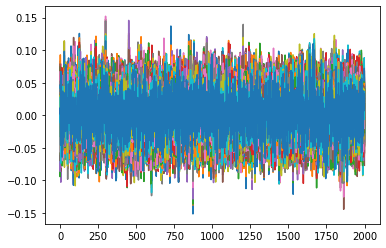

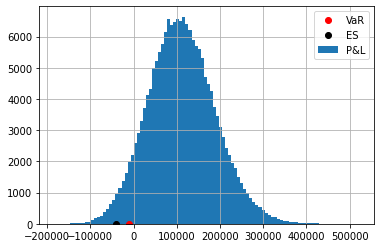

In [12]:
finalCalculation()